<a href="https://colab.research.google.com/github/finiteautomata/sentiment-elecciones/blob/master/notebooks/Dataset_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install datasets

In [ ]:
import json

dataset_path = "dataset.json"

with open(dataset_path) as f:
    data = json.load(f)
    

In [ ]:
data[:10]

[{'id': 23,
  'medio': 'la izquierda diario',
  'targets': [{'etiqueta': 'POS', 'nombre': 'la Izquierda', 'partido': 'FIT'}],
  'titulo': 'Barrio Aeroclub: la Izquierda propone urbanización y adjudicación de terrenos'},
 {'id': 24,
  'medio': 'la izquierda diario',
  'targets': [{'etiqueta': 'POS', 'nombre': 'la izquierda', 'partido': 'FIT'}],
  'titulo': 'Elecciones municipales: el #FITUnidad busca fortalecer la izquierda en la ciudad de Neuquén'},
 {'id': 31,
  'medio': 'la izquierda diario',
  'targets': [{'etiqueta': 'NEU',
    'nombre': 'Frente de Izquierda Unidad',
    'partido': 'FIT'}],
  'titulo': '[Videos] Mirá todos los spots del Frente de Izquierda Unidad en Mendoza'},
 {'id': 39,
  'medio': 'la nacion',
  'targets': [{'etiqueta': 'POS', 'nombre': 'Macri', 'partido': 'JXC'},
   {'etiqueta': 'NEG', 'nombre': 'peronismo', 'partido': 'FDT'}],
  'titulo': 'Entre el milagro de Macri y la grieta del peronismo'},
 {'id': 75,
  'medio': 'la izquierda diario',
  'targets': [{'etique

Convierto esto a un dataframe

In [ ]:
df_rows = []
for row in data:
    row = row.copy()
    targets = row.pop('targets')

    for target in targets:
        new_row = row.copy()
        new_row["target"] = target["nombre"]
        new_row["label"] = target["etiqueta"]
        df_rows.append(new_row)

In [ ]:
len(df_rows), len(data)

(2439, 1976)

In [ ]:
import pandas as pd

df = pd.DataFrame(df_rows)

df

,titulo,id,medio,target,label
0,Barrio Aeroclub: la Izquierda propone urbaniza...,23,la izquierda diario,la Izquierda,POS
1,Elecciones municipales: el #FITUnidad busca fo...,24,la izquierda diario,la izquierda,POS
2,[Videos] Mirá todos los spots del Frente de Iz...,31,la izquierda diario,Frente de Izquierda Unidad,NEU
3,Entre el milagro de Macri y la grieta del pero...,39,la nacion,Macri,POS
4,Entre el milagro de Macri y la grieta del pero...,39,la nacion,peronismo,NEG
...,...,...,...,...,...
2434,"Resultados elecciones 2019: Alberto Fernández,...",22611,la nacion,Alberto Fernández,POS
2435,Elecciones 2019. La llamada de Macri a Alberto...,22612,la nacion,Macri,POS
2436,Video: el particular gesto de Cristina Kirchne...,22616,la nacion,Cristina Kirchner,NEU
2437,Mauricio Macri hizo una gran campaña y Alberto...,22617,la nacion,Mauricio Macri,POS


In [ ]:
df.groupby("id").count()["label"].value_counts()

1    1567
2     363
3      38
4       8
Name: label, dtype: int64

- 1567 con un único target
-  400 con 2 o más

Veamos qué onda la co-ocurrencia entre etiquetas

In [ ]:
df["label"].value_counts()

POS    962
NEU    767
NEG    710
Name: label, dtype: int64

In [ ]:
labels = ["NEG", "NEU", "POS"]

co_ocurrence = pd.DataFrame(index=labels, columns=labels)
co_ocurrence = co_ocurrence.fillna(0)


for row in data:
    if len(row["targets"]) <= 1:
        continue
    
    targets = row["targets"]

    for i in range(len(targets)):
        t1 = targets[i]["etiqueta"]
        for j in range(i+1, len(targets)):
            t2 = targets[j]["etiqueta"]

            co_ocurrence.loc[t1, t2] += 1
            co_ocurrence.loc[t2, t1] += 1



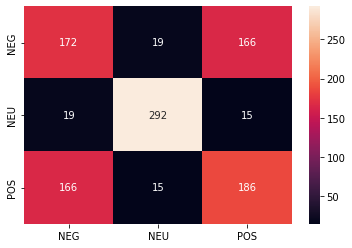

In [ ]:
import seaborn as sns

sns.heatmap(data=co_ocurrence, annot=True, fmt="d")

## Subimos a HF datasets

In [ ]:
df = df.rename({"id": "id_noticia"}, axis=1)

In [ ]:
from sklearn.model_selection import train_test_split

id_noticias = df.groupby("id_noticia").count()["label"]

train_ids, test_ids = train_test_split(id_noticias, stratify=id_noticias.values)
train_ids, dev_ids = train_test_split(train_ids, stratify=train_ids.values)

NameError: ignored

In [ ]:
len(train_ids), len(dev_ids), len(test_ids)

(1111, 371, 494)

In [ ]:
df_train = df[df["id_noticia"].isin(train_ids.index)]
df_dev = df[df["id_noticia"].isin(dev_ids.index)]
df_test = df[df["id_noticia"].isin(test_ids.index)]

df_train.shape, df_dev.shape, df_test.shape

((1371, 5), (459, 5), (609, 5))

In [ ]:
df_train

,titulo,id_noticia,medio,target,label
0,Barrio Aeroclub: la Izquierda propone urbaniza...,23,la izquierda diario,la Izquierda,POS
2,[Videos] Mirá todos los spots del Frente de Iz...,31,la izquierda diario,Frente de Izquierda Unidad,NEU
5,Brutalidad de la Policía de Urtubey en el reci...,75,la izquierda diario,Urtubey,NEG
7,El FIT Unidad amplió sus bancas en el Concejo ...,78,la izquierda diario,FIT Unidad,POS
10,Alberto Fernández ataca a los porteños,90,prensa obrera,Alberto Fernández,NEG
...,...,...,...,...,...
2432,"Cristina Kircher: ""Presidente, por favor, tome...",22605,la nacion,Cristina,POS
2435,Elecciones 2019. La llamada de Macri a Alberto...,22612,la nacion,Macri,POS
2436,Video: el particular gesto de Cristina Kirchne...,22616,la nacion,Cristina Kirchner,NEU
2437,Mauricio Macri hizo una gran campaña y Alberto...,22617,la nacion,Mauricio Macri,POS


In [ ]:
label2id = {"NEG": 0, "NEU": 1, "POS": 2}
df["label"] = df["label"].apply(lambda x: label2id[x])

In [ ]:
df_train

,titulo,id_noticia,medio,target,label,label_int
0,Barrio Aeroclub: la Izquierda propone urbaniza...,23,la izquierda diario,la Izquierda,2,2
2,[Videos] Mirá todos los spots del Frente de Iz...,31,la izquierda diario,Frente de Izquierda Unidad,1,1
5,Brutalidad de la Policía de Urtubey en el reci...,75,la izquierda diario,Urtubey,0,0
7,El FIT Unidad amplió sus bancas en el Concejo ...,78,la izquierda diario,FIT Unidad,2,2
10,Alberto Fernández ataca a los porteños,90,prensa obrera,Alberto Fernández,0,0
...,...,...,...,...,...,...
2432,"Cristina Kircher: ""Presidente, por favor, tome...",22605,la nacion,Cristina,2,2
2435,Elecciones 2019. La llamada de Macri a Alberto...,22612,la nacion,Macri,2,2
2436,Video: el particular gesto de Cristina Kirchne...,22616,la nacion,Cristina Kirchner,1,1
2437,Mauricio Macri hizo una gran campaña y Alberto...,22617,la nacion,Mauricio Macri,2,2


In [ ]:
from datasets import Features, Value, Dataset, ClassLabel

features = Features({
    'titulo': Value('string'),
    'id_noticia': Value('int16'),
    'target': Value('string'),
    'label': ClassLabel(num_classes=3, names=["NEG", "NEU", "POS"])
})




df_train = df[df["id_noticia"].isin(train_ids.index)]
df_dev = df[df["id_noticia"].isin(dev_ids.index)]
df_test = df[df["id_noticia"].isin(test_ids.index)]

columns = ["titulo", "id_noticia", "target", "label"]

train_dataset = Dataset.from_pandas(df_train[columns], features=features)
dev_dataset = Dataset.from_pandas(df_dev[columns], features=features)
test_dataset = Dataset.from_pandas(df_test[columns], features=features)

In [ ]:
from datasets import DatasetDict

dataset = DatasetDict(
    train=train_dataset,
    dev=dev_dataset,
    test=test_dataset,
)

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [ ]:
dataset.push_to_hub("finiteautomata/tsa")

Pushing split train to the Hub.


Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Pushing split dev to the Hub.


Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Pushing split test to the Hub.


Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]